# Energy Grid Mapping with GeoPandas

This notebook demonstrates how to use GeoPandas for energy grid infrastructure analysis and mapping.

## Topics Covered:
1. Creating synthetic power grid infrastructure
2. Mapping power generation facilities
3. Transmission line network analysis
4. Service area analysis and coverage
5. Finding nearest substations to demand points
6. Grid connectivity analysis
7. Identifying coverage gaps
8. Interactive visualization with Folium


In [1]:
# Fix for PROJ database path issue
import os
import sys

# Set environment variables to use Homebrew PROJ installation
os.environ['PROJ_DATA'] = '/opt/homebrew/share/proj'
os.environ['PROJ_LIB'] = '/opt/homebrew/share/proj'
os.environ['PROJ_NETWORK'] = 'OFF'

# Now import pyproj
import pyproj
from pyproj import datadir

# Set data directory to Homebrew PROJ
datadir.set_data_dir('/opt/homebrew/share/proj')

print(f"✓ pyproj {pyproj.__version__}")
print(f"✓ PROJ data dir: {datadir.get_data_dir()}")

# Test CRS creation
try:
    from pyproj import CRS
    test_crs = CRS.from_epsg(4326)
    print(f"✓ CRS working: {test_crs.name}")
except Exception as e:
    print(f"✗ CRS failed: {e}")


✓ pyproj 3.7.2
✓ PROJ data dir: /opt/homebrew/share/proj
✓ CRS working: WGS 84


In [2]:
# Import required libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import numpy as np
import folium
from folium import plugins

# Set random seed for reproducibility
np.random.seed(42)

# Set display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (14, 10)


## 1. Creating Synthetic Power Grid Infrastructure

Let's create a realistic power grid network for a hypothetical region.


In [3]:
# Define the study area (roughly Texas-sized region)
study_area_bounds = {'min_lon': -100, 'max_lon': -94, 'min_lat': 29, 'max_lat': 34}

# Create study area polygon
study_area = Polygon([
    (study_area_bounds['min_lon'], study_area_bounds['min_lat']),
    (study_area_bounds['max_lon'], study_area_bounds['min_lat']),
    (study_area_bounds['max_lon'], study_area_bounds['max_lat']),
    (study_area_bounds['min_lon'], study_area_bounds['max_lat'])
])

study_area_gdf = gpd.GeoDataFrame({'name': ['Study Area']}, geometry=[study_area], crs='EPSG:4326')

print(f"Study Area: {study_area.bounds}")
print(f"Area: ~{study_area_gdf.to_crs('EPSG:3857').geometry.area[0] / 1e6:.0f} km²")


Study Area: (-100.0, 29.0, -94.0, 34.0)
Area: ~436254 km²


### 1.1 Power Generation Facilities


In [4]:
# Create power plants with different types
power_plants_data = {
    'name': [
        'Coal Creek Power Station', 'Solar Valley Array', 'Wind River Farm', 
        'Natural Gas Plant 1', 'Hydroelectric Dam', 'Nuclear Power Station',
        'Solar Farm East', 'Wind Farm North', 'Natural Gas Plant 2'
    ],
    'type': [
        'Coal', 'Solar', 'Wind', 'Natural Gas', 'Hydro', 'Nuclear',
        'Solar', 'Wind', 'Natural Gas'
    ],
    'capacity_mw': [800, 150, 300, 500, 200, 1200, 200, 350, 450],
    'lon': [-99.5, -96.5, -95.2, -97.8, -98.5, -96.0, -94.8, -99.0, -96.8],
    'lat': [31.5, 30.2, 32.8, 29.8, 33.2, 31.8, 31.0, 33.8, 30.5]
}

power_plants_geom = [Point(lon, lat) for lon, lat in zip(power_plants_data['lon'], power_plants_data['lat'])]
power_plants = gpd.GeoDataFrame(power_plants_data, geometry=power_plants_geom, crs='EPSG:4326')

# Add color coding for plant types
type_colors = {
    'Coal': 'black',
    'Solar': 'yellow',
    'Wind': 'lightblue',
    'Natural Gas': 'orange',
    'Hydro': 'blue',
    'Nuclear': 'red'
}
power_plants['color'] = power_plants['type'].map(type_colors)

print("Power Generation Facilities:")
print(power_plants[['name', 'type', 'capacity_mw']])
print(f"\nTotal Capacity: {power_plants['capacity_mw'].sum()} MW")


Power Generation Facilities:
                       name         type  capacity_mw
0  Coal Creek Power Station         Coal          800
1        Solar Valley Array        Solar          150
2           Wind River Farm         Wind          300
3       Natural Gas Plant 1  Natural Gas          500
4         Hydroelectric Dam        Hydro          200
5     Nuclear Power Station      Nuclear         1200
6           Solar Farm East        Solar          200
7           Wind Farm North         Wind          350
8       Natural Gas Plant 2  Natural Gas          450

Total Capacity: 4150 MW


### 1.2 Substations


In [5]:
# Create substations distributed across the region
n_substations = 25

substations_data = {
    'id': [f'SUB-{i+1:03d}' for i in range(n_substations)],
    'voltage_kv': np.random.choice([138, 230, 345, 500], n_substations),
    'lon': np.random.uniform(study_area_bounds['min_lon'], study_area_bounds['max_lon'], n_substations),
    'lat': np.random.uniform(study_area_bounds['min_lat'], study_area_bounds['max_lat'], n_substations)
}

substations_geom = [Point(lon, lat) for lon, lat in zip(substations_data['lon'], substations_data['lat'])]
substations = gpd.GeoDataFrame(substations_data, geometry=substations_geom, crs='EPSG:4326')

print(f"Number of Substations: {len(substations)}")
print(f"\nVoltage Distribution:")
print(substations['voltage_kv'].value_counts().sort_index())


Number of Substations: 25

Voltage Distribution:
voltage_kv
138    5
230    3
345    9
500    8
Name: count, dtype: int64


### 1.3 Transmission Lines


In [6]:
# Create transmission lines connecting power plants to substations and between substations
transmission_lines = []

# Connect each power plant to nearest 2-3 substations
for idx, plant in power_plants.iterrows():
    # Calculate distances to all substations
    distances = substations.geometry.distance(plant.geometry)
    nearest_subs = distances.nsmallest(3).index
    
    for sub_idx in nearest_subs:
        line = LineString([plant.geometry.coords[0], substations.loc[sub_idx, 'geometry'].coords[0]])
        transmission_lines.append({
            'from_type': 'Plant',
            'from_name': plant['name'],
            'to_type': 'Substation',
            'to_name': substations.loc[sub_idx, 'id'],
            'voltage_kv': substations.loc[sub_idx, 'voltage_kv'],
            'geometry': line
        })

# Connect some substations to each other (create a mesh network)
for i in range(len(substations) - 1):
    for j in range(i + 1, min(i + 4, len(substations))):  # Connect to next 3 substations
        if np.random.random() > 0.5:  # Randomly connect some
            line = LineString([
                substations.iloc[i].geometry.coords[0],
                substations.iloc[j].geometry.coords[0]
            ])
            transmission_lines.append({
                'from_type': 'Substation',
                'from_name': substations.iloc[i]['id'],
                'to_type': 'Substation',
                'to_name': substations.iloc[j]['id'],
                'voltage_kv': min(substations.iloc[i]['voltage_kv'], substations.iloc[j]['voltage_kv']),
                'geometry': line
            })

transmission_gdf = gpd.GeoDataFrame(transmission_lines, crs='EPSG:4326')

# Calculate line lengths in km
transmission_gdf_projected = transmission_gdf.to_crs('EPSG:3857')
transmission_gdf['length_km'] = transmission_gdf_projected.geometry.length / 1000

print(f"Number of Transmission Lines: {len(transmission_gdf)}")
print(f"Total Network Length: {transmission_gdf['length_km'].sum():.0f} km")
print(f"Average Line Length: {transmission_gdf['length_km'].mean():.1f} km")


Number of Transmission Lines: 59
Total Network Length: 14853 km
Average Line Length: 251.8 km


## 2. Visualizing the Power Grid Network


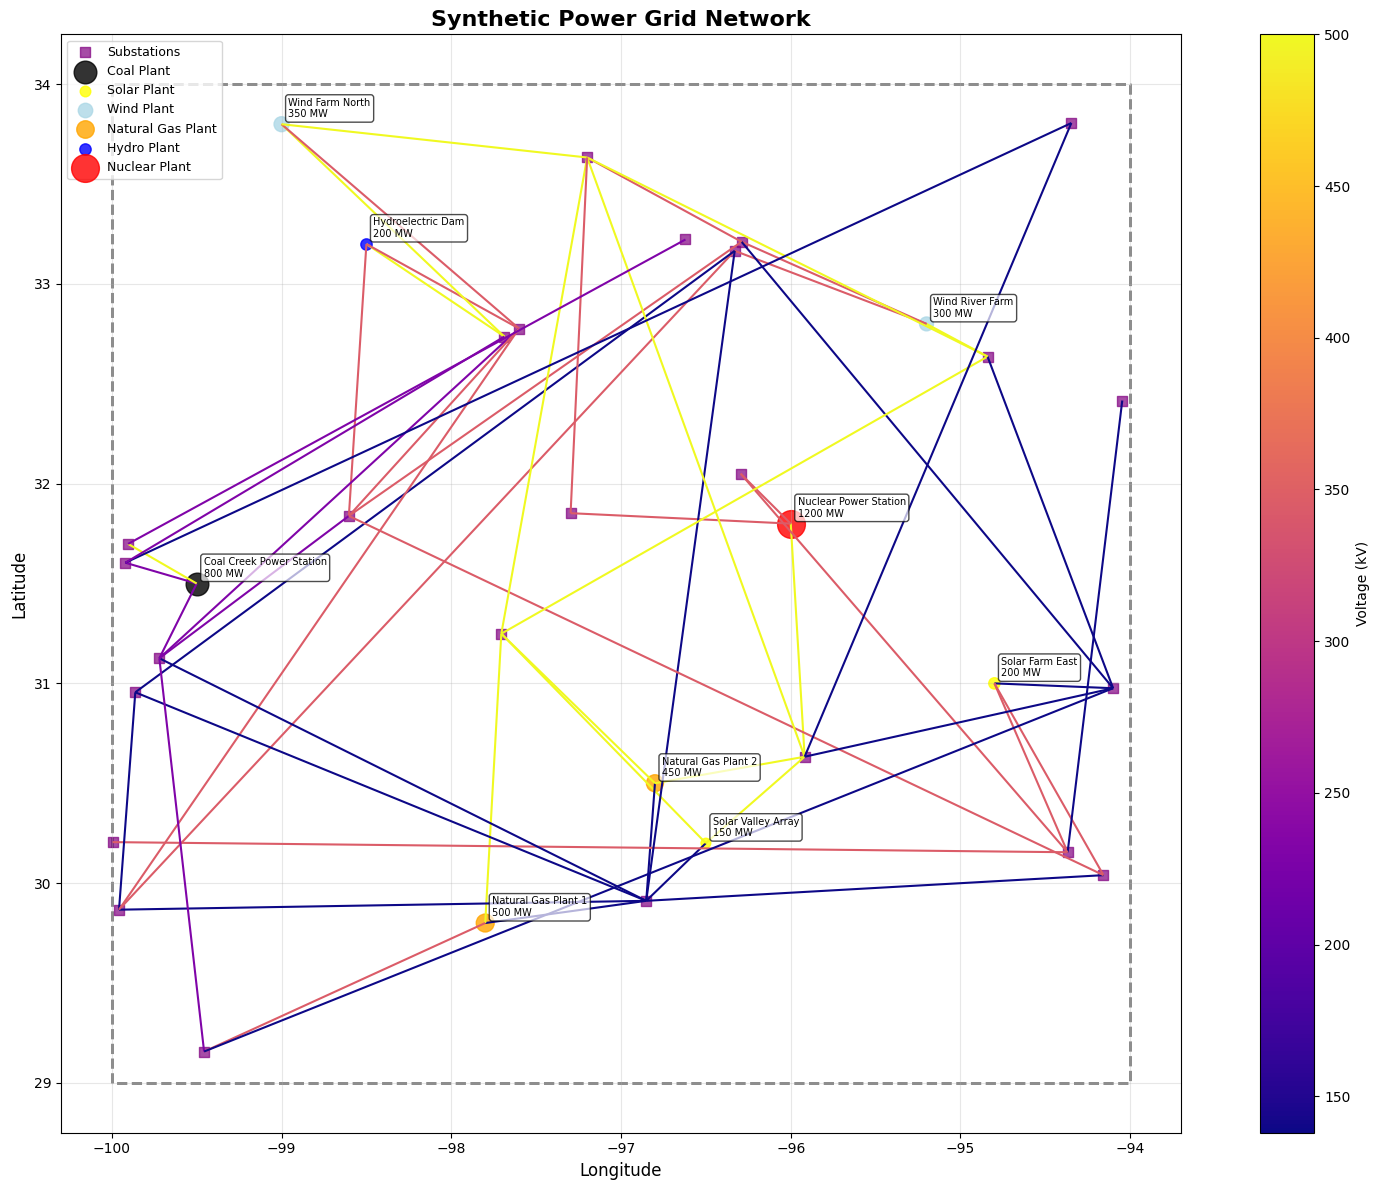

In [7]:
# Create a comprehensive map
fig, ax = plt.subplots(figsize=(16, 12))

# Plot study area
study_area_gdf.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=2, linestyle='--', label='Study Area')

# Plot transmission lines (colored by voltage)
transmission_gdf.plot(ax=ax, column='voltage_kv', cmap='plasma', linewidth=1.5, 
                      legend=True, legend_kwds={'label': 'Voltage (kV)'})

# Plot substations
substations.plot(ax=ax, color='purple', marker='s', markersize=50, alpha=0.7, label='Substations')

# Plot power plants (sized by capacity, colored by type)
for plant_type in power_plants['type'].unique():
    plants_subset = power_plants[power_plants['type'] == plant_type]
    plants_subset.plot(ax=ax, color=type_colors[plant_type], marker='o', 
                      markersize=plants_subset['capacity_mw']/3, 
                      alpha=0.8, label=f'{plant_type} Plant')

# Add labels for power plants
for idx, row in power_plants.iterrows():
    ax.annotate(f"{row['name']}\n{row['capacity_mw']} MW", 
                xy=(row.geometry.x, row.geometry.y),
                xytext=(5, 5), textcoords='offset points', fontsize=7,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.title('Synthetic Power Grid Network', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Service Area Analysis

Calculate service areas around substations using buffers.


In [8]:
# Project to appropriate CRS for distance calculations
substations_projected = substations.to_crs('EPSG:3857')

# Create service area buffers (50km radius)
service_radius = 50_000  # 50 km in meters
substations_projected['service_area'] = substations_projected.geometry.buffer(service_radius)

# Create separate GeoDataFrame for service areas
service_areas = substations_projected.copy()
service_areas.set_geometry('service_area', inplace=True)

# Convert back to geographic CRS for plotting
service_areas_geo = service_areas.to_crs('EPSG:4326')

# Calculate coverage
study_area_projected = study_area_gdf.to_crs('EPSG:3857')
total_coverage = service_areas.unary_union
coverage_polygon = total_coverage.intersection(study_area_projected.geometry.iloc[0])

coverage_percentage = (coverage_polygon.area / study_area_projected.geometry.area.iloc[0]) * 100

print(f"Service radius: {service_radius/1000} km")
print(f"Coverage: {coverage_percentage:.1f}% of study area")


Service radius: 50.0 km
Coverage: 29.9% of study area


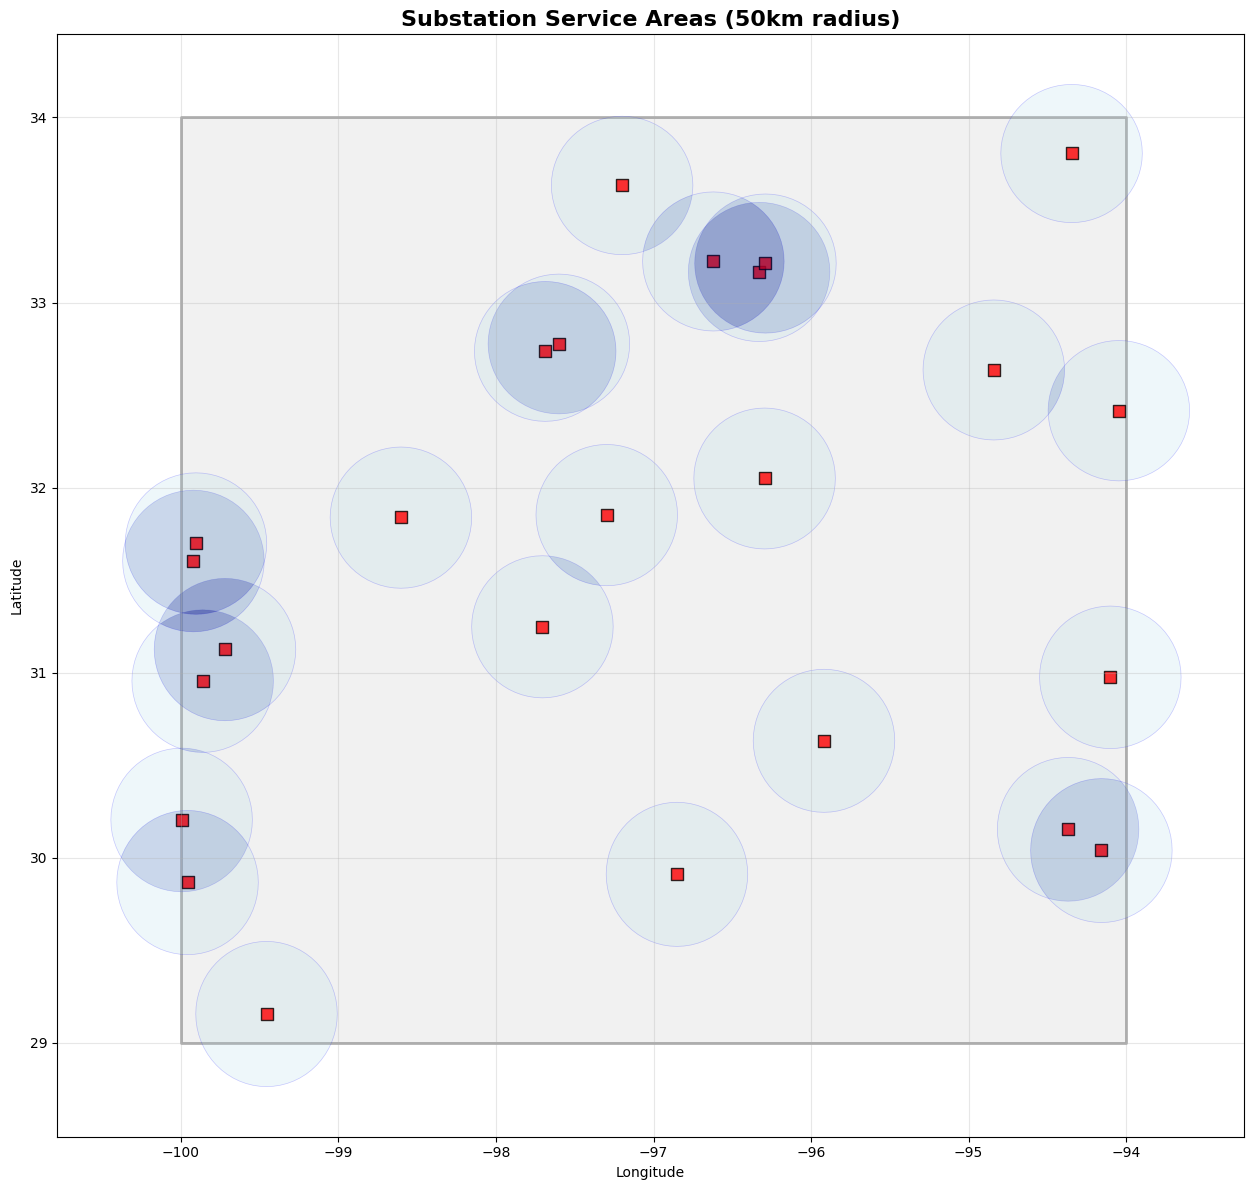

In [9]:
# Visualize service areas
fig, ax = plt.subplots(figsize=(16, 12))

# Plot study area
study_area_gdf.plot(ax=ax, facecolor='lightgray', edgecolor='black', linewidth=2, alpha=0.3)

# Plot service areas
service_areas_geo.plot(ax=ax, color='lightblue', alpha=0.2, edgecolor='blue', linewidth=0.5)

# Plot substations
substations.plot(ax=ax, color='red', marker='s', markersize=80, alpha=0.8, edgecolor='black', linewidth=1)

# Highlight overlap areas (areas served by multiple substations)
from shapely.ops import unary_union
for i, area1 in service_areas_geo.iterrows():
    for j, area2 in service_areas_geo.iterrows():
        if i < j:
            overlap = area1['service_area'].intersection(area2['service_area'])
            if not overlap.is_empty:
                gpd.GeoSeries([overlap], crs='EPSG:4326').plot(ax=ax, color='darkblue', alpha=0.1)

plt.title('Substation Service Areas (50km radius)', fontsize=16, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 4. Finding Nearest Substations to Demand Points


In [10]:
# Create demand points (cities, industrial areas)
demand_points_data = {
    'name': ['City A', 'City B', 'City C', 'Industrial Zone 1', 'City D', 'Industrial Zone 2', 'City E'],
    'type': ['City', 'City', 'City', 'Industrial', 'City', 'Industrial', 'City'],
    'demand_mw': [150, 200, 100, 300, 180, 250, 120],
    'lon': [-98.2, -96.0, -95.5, -99.0, -97.5, -94.8, -96.5],
    'lat': [32.0, 30.8, 33.5, 30.2, 31.5, 32.8, 29.5]
}

demand_geom = [Point(lon, lat) for lon, lat in zip(demand_points_data['lon'], demand_points_data['lat'])]
demand_points = gpd.GeoDataFrame(demand_points_data, geometry=demand_geom, crs='EPSG:4326')

# Find nearest substation for each demand point
demand_points_projected = demand_points.to_crs('EPSG:3857')

nearest_substations = []
distances_km = []

for idx, demand in demand_points_projected.iterrows():
    # Calculate distances to all substations
    distances = substations_projected.geometry.distance(demand.geometry)
    nearest_idx = distances.idxmin()
    nearest_dist = distances.min() / 1000  # Convert to km
    
    nearest_substations.append(substations.loc[nearest_idx, 'id'])
    distances_km.append(nearest_dist)

demand_points['nearest_substation'] = nearest_substations
demand_points['distance_km'] = distances_km

print("Demand Points and Nearest Substations:")
print(demand_points[['name', 'type', 'demand_mw', 'nearest_substation', 'distance_km']])
print(f"\nAverage distance to nearest substation: {demand_points['distance_km'].mean():.1f} km")


Demand Points and Nearest Substations:
                name        type  demand_mw nearest_substation  distance_km
0             City A        City        150            SUB-012    49.647856
1             City B        City        200            SUB-019    23.500441
2             City C        City        100            SUB-014    95.952143
3  Industrial Zone 1  Industrial        300            SUB-002   110.801308
4             City D        City        180            SUB-015    39.936287
5  Industrial Zone 2  Industrial        250            SUB-018    22.112772
6             City E        City        120            SUB-008    65.626589

Average distance to nearest substation: 58.2 km


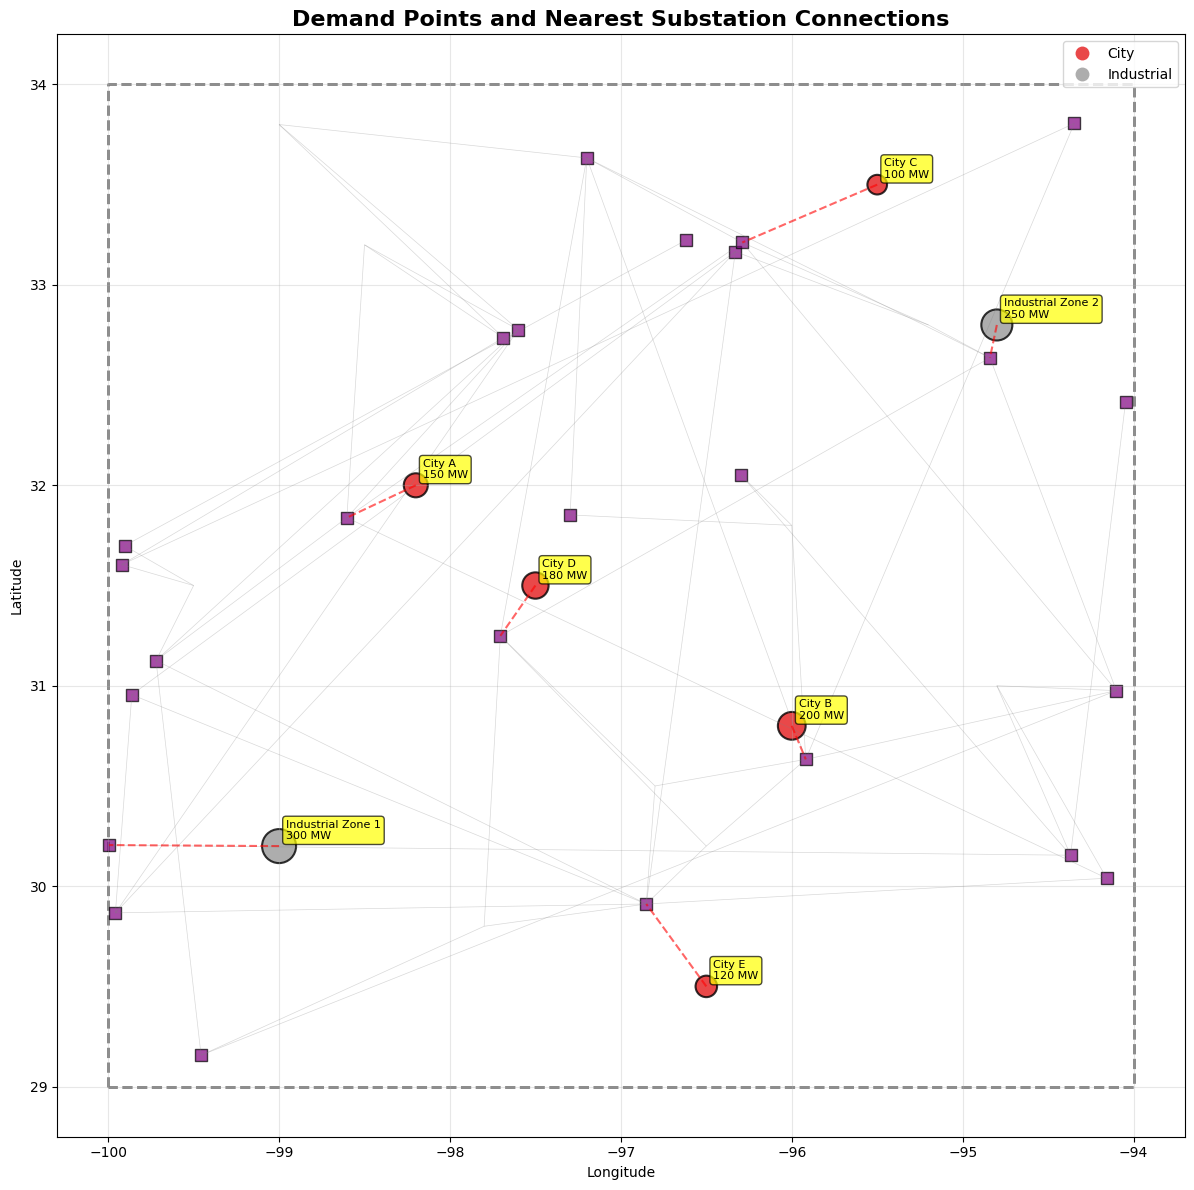

In [11]:
# Visualize demand points with connections to nearest substations
fig, ax = plt.subplots(figsize=(16, 12))

# Plot study area and transmission lines
study_area_gdf.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=2, linestyle='--')
transmission_gdf.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.3)

# Plot substations
substations.plot(ax=ax, color='purple', marker='s', markersize=80, alpha=0.7, 
                 edgecolor='black', linewidth=1, label='Substations')

# Plot demand points
demand_points.plot(ax=ax, column='type', categorical=True, legend=True, 
                   markersize=demand_points['demand_mw']*2, alpha=0.8,
                   cmap='Set1', edgecolor='black', linewidth=1.5)

# Draw lines from demand points to nearest substations
for idx, demand in demand_points.iterrows():
    nearest_sub_id = demand['nearest_substation']
    nearest_sub = substations[substations['id'] == nearest_sub_id].iloc[0]
    
    line_coords = [demand.geometry.coords[0], nearest_sub.geometry.coords[0]]
    ax.plot([line_coords[0][0], line_coords[1][0]], 
            [line_coords[0][1], line_coords[1][1]], 
            'r--', linewidth=1.5, alpha=0.6)
    
    # Add labels
    ax.annotate(f"{demand['name']}\n{demand['demand_mw']} MW", 
                xy=(demand.geometry.x, demand.geometry.y),
                xytext=(5, 5), textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.title('Demand Points and Nearest Substation Connections', fontsize=16, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Coverage Gap Analysis

Identify areas not adequately served by the current grid infrastructure.


In [12]:
# Calculate coverage gaps
from shapely.ops import unary_union

# Get total service area coverage
total_service_area = unary_union(service_areas.geometry)

# Calculate gap areas (study area minus service coverage)
study_area_proj = study_area_projected.geometry.iloc[0]
coverage_gaps = study_area_proj.difference(total_service_area)

# Convert to GeoDataFrame for plotting
if coverage_gaps.geom_type == 'Polygon':
    gap_geometries = [coverage_gaps]
elif coverage_gaps.geom_type == 'MultiPolygon':
    gap_geometries = list(coverage_gaps.geoms)
else:
    gap_geometries = []

gaps_gdf = gpd.GeoDataFrame(geometry=gap_geometries, crs='EPSG:3857')
gaps_gdf_geo = gaps_gdf.to_crs('EPSG:4326')

# Calculate gap statistics
if len(gaps_gdf) > 0:
    gaps_gdf['area_km2'] = gaps_gdf.geometry.area / 1_000_000
    total_gap_area = gaps_gdf['area_km2'].sum()
    study_area_km2 = study_area_proj.area / 1_000_000
    gap_percentage = (total_gap_area / study_area_km2) * 100
    
    print(f"Coverage Gap Analysis:")
    print(f"Total gap area: {total_gap_area:.0f} km²")
    print(f"Percentage of study area with gaps: {gap_percentage:.1f}%")
    print(f"Number of gap regions: {len(gaps_gdf)}")
else:
    print("No coverage gaps - complete coverage achieved!")


Coverage Gap Analysis:
Total gap area: 305698 km²
Percentage of study area with gaps: 70.1%
Number of gap regions: 1


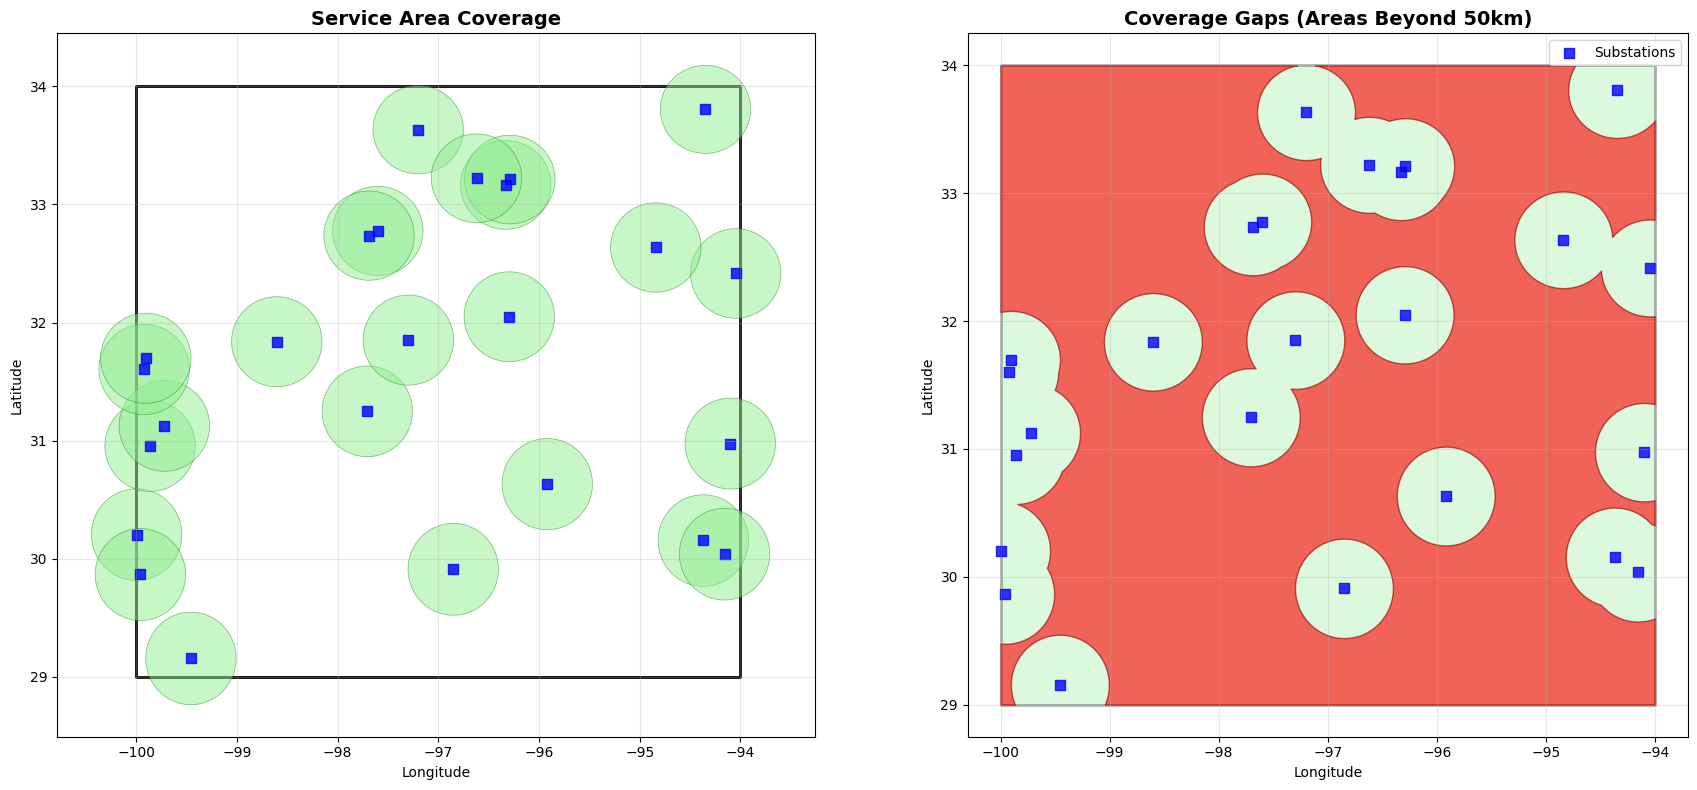

In [13]:
# Visualize coverage gaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left: Service areas
study_area_gdf.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=2)
service_areas_geo.plot(ax=ax1, color='lightgreen', alpha=0.5, edgecolor='green', linewidth=0.5)
substations.plot(ax=ax1, color='blue', marker='s', markersize=50, alpha=0.8)
ax1.set_title('Service Area Coverage', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True, alpha=0.3)

# Right: Coverage gaps
study_area_gdf.plot(ax=ax2, facecolor='lightgreen', edgecolor='black', linewidth=2, alpha=0.3, label='Covered')
if len(gaps_gdf_geo) > 0:
    gaps_gdf_geo.plot(ax=ax2, color='red', alpha=0.6, edgecolor='darkred', linewidth=1, label='Coverage Gaps')
substations.plot(ax=ax2, color='blue', marker='s', markersize=50, alpha=0.8, label='Substations')
ax2.set_title('Coverage Gaps (Areas Beyond 50km)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Transmission Corridor Analysis

Analyze areas within transmission line corridors for planning and environmental impact.


In [14]:
# Create transmission corridors (buffers around transmission lines)
transmission_projected = transmission_gdf.to_crs('EPSG:3857')

# Different corridor widths based on voltage
def get_corridor_width(voltage_kv):
    if voltage_kv >= 500:
        return 500  # 500m for 500kV lines
    elif voltage_kv >= 345:
        return 400  # 400m for 345kV lines
    elif voltage_kv >= 230:
        return 300  # 300m for 230kV lines
    else:
        return 200  # 200m for lower voltage

transmission_projected['corridor_width'] = transmission_projected['voltage_kv'].apply(get_corridor_width)
transmission_projected['corridor'] = transmission_projected.apply(
    lambda row: row.geometry.buffer(row['corridor_width']), axis=1
)

corridors_gdf = transmission_projected.copy()
corridors_gdf.set_geometry('corridor', inplace=True)
corridors_gdf.set_crs('EPSG:3857', inplace=True)  # Set CRS after changing geometry column
corridors_geo = corridors_gdf.to_crs('EPSG:4326')

# Calculate total corridor area
total_corridor_area = corridors_gdf.unary_union.area / 1_000_000  # km²

print(f"Transmission Corridor Analysis:")
print(f"Total corridor area: {total_corridor_area:.0f} km²")
print(f"Average corridor width: {transmission_projected['corridor_width'].mean():.0f} m")


Transmission Corridor Analysis:
Total corridor area: 9674 km²
Average corridor width: 353 m


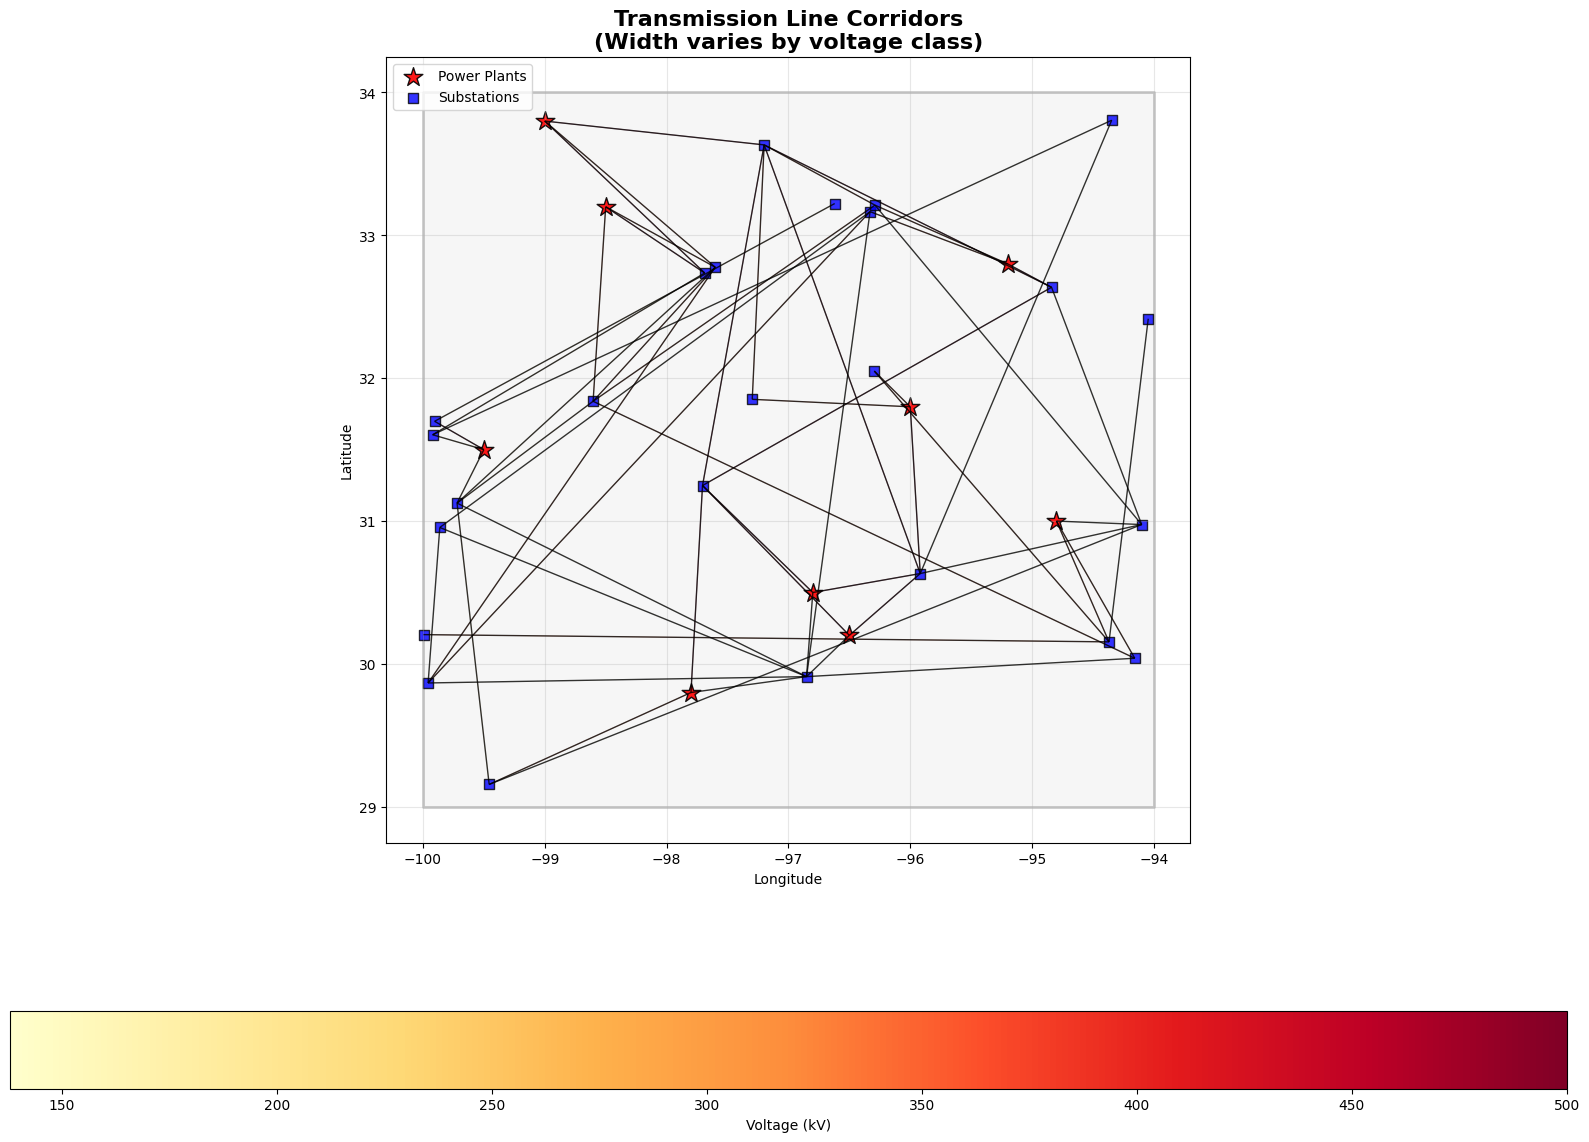

In [15]:
# Visualize transmission corridors
fig, ax = plt.subplots(figsize=(16, 12))

# Plot study area
study_area_gdf.plot(ax=ax, facecolor='lightgray', edgecolor='black', linewidth=2, alpha=0.2)

# Plot corridors colored by voltage
corridors_geo.plot(ax=ax, column='voltage_kv', cmap='YlOrRd', alpha=0.4, 
                   edgecolor='none', legend=True, 
                   legend_kwds={'label': 'Voltage (kV)', 'orientation': 'horizontal'})

# Plot transmission lines
transmission_gdf.plot(ax=ax, color='black', linewidth=1, alpha=0.8)

# Plot infrastructure
power_plants.plot(ax=ax, color='red', marker='*', markersize=200, alpha=0.9, 
                  edgecolor='black', linewidth=1, label='Power Plants')
substations.plot(ax=ax, color='blue', marker='s', markersize=60, alpha=0.8, 
                edgecolor='black', linewidth=1, label='Substations')

plt.title('Transmission Line Corridors\n(Width varies by voltage class)', fontsize=16, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Interactive Map with Folium

Create an interactive web map for better visualization and exploration.


In [16]:
# Create interactive map centered on study area
center_lat = (study_area_bounds['min_lat'] + study_area_bounds['max_lat']) / 2
center_lon = (study_area_bounds['min_lon'] + study_area_bounds['max_lon']) / 2

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=7,
    tiles='OpenStreetMap'
)

# Add transmission lines
for idx, row in transmission_gdf.iterrows():
    coords = [(coord[1], coord[0]) for coord in row.geometry.coords]
    folium.PolyLine(
        coords,
        color='purple',
        weight=2,
        opacity=0.6,
        popup=f"From: {row['from_name']}<br>To: {row['to_name']}<br>Voltage: {row['voltage_kv']} kV<br>Length: {row['length_km']:.1f} km"
    ).add_to(m)

# Add substations
for idx, row in substations.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color='blue',
        fill=True,
        fillColor='lightblue',
        fillOpacity=0.7,
        popup=f"<b>{row['id']}</b><br>Voltage: {row['voltage_kv']} kV"
    ).add_to(m)

# Add power plants
for idx, row in power_plants.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"<b>{row['name']}</b><br>Type: {row['type']}<br>Capacity: {row['capacity_mw']} MW",
        tooltip=row['name'],
        icon=folium.Icon(color='red', icon='bolt', prefix='fa')
    ).add_to(m)

# Add demand points
for idx, row in demand_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=8,
        color='orange',
        fill=True,
        fillColor='yellow',
        fillOpacity=0.8,
        popup=f"<b>{row['name']}</b><br>Type: {row['type']}<br>Demand: {row['demand_mw']} MW<br>Nearest Sub: {row['nearest_substation']}<br>Distance: {row['distance_km']:.1f} km"
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m


## 8. Grid Analytics and Statistics


In [17]:
# Comprehensive grid statistics
print("="*60)
print("POWER GRID NETWORK STATISTICS")
print("="*60)

print("\n1. GENERATION CAPACITY:")
print(f"   Total Capacity: {power_plants['capacity_mw'].sum():,} MW")
print("\n   By Type:")
for plant_type in power_plants['type'].unique():
    capacity = power_plants[power_plants['type'] == plant_type]['capacity_mw'].sum()
    percentage = (capacity / power_plants['capacity_mw'].sum()) * 100
    print(f"   - {plant_type}: {capacity} MW ({percentage:.1f}%)")

print("\n2. TRANSMISSION NETWORK:")
print(f"   Total Lines: {len(transmission_gdf)}")
print(f"   Total Length: {transmission_gdf['length_km'].sum():.0f} km")
print(f"   Average Length: {transmission_gdf['length_km'].mean():.1f} km")
print("\n   By Voltage Class:")
for voltage in sorted(transmission_gdf['voltage_kv'].unique()):
    count = len(transmission_gdf[transmission_gdf['voltage_kv'] == voltage])
    length = transmission_gdf[transmission_gdf['voltage_kv'] == voltage]['length_km'].sum()
    print(f"   - {voltage} kV: {count} lines, {length:.0f} km")

print("\n3. SUBSTATIONS:")
print(f"   Total Substations: {len(substations)}")
print("\n   By Voltage Class:")
for voltage in sorted(substations['voltage_kv'].unique()):
    count = len(substations[substations['voltage_kv'] == voltage])
    print(f"   - {voltage} kV: {count} substations")

print("\n4. DEMAND:")
print(f"   Total Demand Points: {len(demand_points)}")
print(f"   Total Demand: {demand_points['demand_mw'].sum()} MW")
print(f"   Average Distance to Substation: {demand_points['distance_km'].mean():.1f} km")
print(f"   Max Distance to Substation: {demand_points['distance_km'].max():.1f} km")

print("\n5. COVERAGE:")
print(f"   Service Radius: {service_radius/1000} km")
print(f"   Coverage: {coverage_percentage:.1f}% of study area")

print("\n" + "="*60)


POWER GRID NETWORK STATISTICS

1. GENERATION CAPACITY:
   Total Capacity: 4,150 MW

   By Type:
   - Coal: 800 MW (19.3%)
   - Solar: 350 MW (8.4%)
   - Wind: 650 MW (15.7%)
   - Natural Gas: 950 MW (22.9%)
   - Hydro: 200 MW (4.8%)
   - Nuclear: 1200 MW (28.9%)

2. TRANSMISSION NETWORK:
   Total Lines: 59
   Total Length: 14853 km
   Average Length: 251.8 km

   By Voltage Class:
   - 138 kV: 18 lines, 5633 km
   - 230 kV: 7 lines, 1541 km
   - 345 kV: 19 lines, 4811 km
   - 500 kV: 15 lines, 2868 km

3. SUBSTATIONS:
   Total Substations: 25

   By Voltage Class:
   - 138 kV: 5 substations
   - 230 kV: 3 substations
   - 345 kV: 9 substations
   - 500 kV: 8 substations

4. DEMAND:
   Total Demand Points: 7
   Total Demand: 1300 MW
   Average Distance to Substation: 58.2 km
   Max Distance to Substation: 110.8 km

5. COVERAGE:
   Service Radius: 50.0 km
   Coverage: 29.9% of study area



## Summary

In this notebook, we demonstrated comprehensive energy grid mapping and analysis using GeoPandas:

**Infrastructure Modeling:**
- Created synthetic power generation facilities with different types and capacities
- Modeled substations with various voltage classes
- Generated realistic transmission line networks

**Spatial Analysis:**
- Service area analysis using buffers
- Nearest facility analysis for demand points
- Coverage gap identification
- Transmission corridor mapping

**Advanced Operations:**
- Distance calculations between grid components
- Network connectivity analysis
- Spatial overlays and intersections
- Multi-criteria spatial queries

**Visualization:**
- Static maps with matplotlib showing different aspects of the grid
- Interactive web maps with Folium for exploration
- Color-coded visualizations by attributes (voltage, capacity, type)

**Key Insights:**
- GeoPandas is excellent for energy infrastructure planning and analysis
- Spatial operations help identify coverage gaps and optimize placement
- Distance calculations support grid connectivity decisions
- Interactive maps enable stakeholder communication

These techniques can be applied to real-world energy grid data for infrastructure planning, maintenance optimization, and expansion strategies!
